# Mean-Variance Optimization

In [1]:
import sys

from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns

In [2]:
# 경로설정

CWD = Path.cwd()
WORKSPACE_PATH = CWD.parent
COMMON_PATH = WORKSPACE_PATH / 'common'
DATA_PATH = WORKSPACE_PATH / 'data'
FONT_PATH = COMMON_PATH / 'fonts' / 'NanumGothic.ttf'

In [3]:
font_prop = font_manager.FontProperties(fname=FONT_PATH)
rc('font', family=font_prop.get_name())

In [4]:
sys.path.append(str(COMMON_PATH))

In [5]:
import fn_loader as fn
import fn_config as fncfg
import gaps_config as gcfg

from validator import *
from backtest import Backtest

## Import Data

In [6]:
# loader 생성 (데이터 로드 + multi index로 전처리)
# use_alias=True 일 경우 긴 ETF명 대신 축약한 단어 사용
pricevolume1 = fn.FnDataLoader('DBGAPS2024_pricevolume_240722.xlsx', use_alias=True)  

In [7]:
pricevolume1.get_datafields()

Index(['return', 'adjopen', 'adjhigh', 'adjlow', 'adjclose', 'moneyvolume'], dtype='object')

In [8]:
# pricevolume2 = fn.FnDataLoader('DBGAPS2024_pricevolume2.xlsx', use_alias=True)

In [9]:
# pricevolume2.get_datafields()

In [10]:
return_df = pricevolume1.get_data('return') / 100 # 
return_df.head() 

,shortterm,usd,usdinv,kodexinv,oil,gold,hybond,midbond,10y,csi300,nikkei,euro50,sp500,kosdaq150,kodex200
Date,,,,,,,,,,,,,,,
2016-03-04,0.0000,-0.0096,0.0092,-0.0012,0.0127,0.0183,0.0037,-0.0020,-0.0019,0.0042,0.0019,-0.0046,0.0043,0.0028,0.0002
2016-03-07,0.0000,-0.0036,0.0019,-0.0024,0.0458,-0.0021,0.0037,0.0017,0.0000,0.0048,-0.0024,-0.0005,0.0006,-0.0051,0.0021
2016-03-08,-0.0001,0.0045,-0.0043,0.0079,0.0093,0.0067,0.0005,0.0000,0.0029,-0.0089,-0.0048,-0.0005,-0.0011,0.0009,-0.0070
2016-03-09,0.0002,0.0097,-0.0082,-0.0042,-0.0145,-0.0107,-0.0005,-0.0014,-0.0005,-0.0035,-0.0100,-0.0057,-0.0021,0.0060,0.0043
2016-03-10,-0.0001,-0.0108,0.0112,-0.0073,0.0174,-0.0046,-0.0010,0.0019,-0.0010,0.0021,0.0116,0.0010,0.0017,0.0055,0.0092


## MVO

In [11]:
# Parameters

WINDOW = 20

In [12]:
# Function to compute the tangent portfolio weights using closed-form solution
def tangent_portfolio_weights(mean_returns, cov_matrix):
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    ones = np.ones(len(mean_returns))
    tangent_weights = np.dot(inv_cov_matrix, mean_returns)
    tangent_weights /= np.dot(ones, tangent_weights)
    return tangent_weights


In [13]:
# List to store the results and their corresponding dates
tangent_portfolios = []
rebalance_dates = []

# Loop through the dataset with the specified window
for start in range(0, len(return_df) - WINDOW + 1, WINDOW):
    end = start + WINDOW
    window_data = return_df[start:end]
    
    # Calculate the mean returns and covariance matrix for the window
    mean_returns = window_data.mean().values
    cov_matrix = window_data.cov().values
    
    # Compute the tangent portfolio weights using the closed-form solution
    tangent_weights = tangent_portfolio_weights(mean_returns, cov_matrix)
    
    # Store the tangent portfolio weights and the corresponding rebalance date
    tangent_portfolios.append(tangent_weights)
    rebalance_dates.append(return_df.index[end-1])

# Convert the list of tangent portfolios to a DataFrame
tangent_portfolios_df = pd.DataFrame(tangent_portfolios, index=rebalance_dates, columns=return_df.columns)

# Display the resulting DataFrame of tangent portfolio weights
tangent_portfolios_df.head()


,shortterm,usd,usdinv,kodexinv,oil,gold,hybond,midbond,10y,csi300,nikkei,euro50,sp500,kosdaq150,kodex200
2016-03-31,0.948809,0.011406,0.018267,-0.011582,0.005114,-0.015002,0.015295,-0.018544,0.041146,-0.016203,-0.000289,-0.009118,0.046988,-0.011598,-0.004691
2016-04-29,0.915505,0.032745,0.028287,0.069302,0.006757,-0.025602,0.059729,-0.279076,0.154339,-0.012394,-0.010097,0.004433,0.004437,-0.005199,0.056833
2016-05-31,1.119990,-0.101811,-0.121403,0.012105,0.004959,-0.000730,0.025001,-0.086753,0.125693,0.008237,-0.004628,0.020287,0.011496,-0.006049,-0.006394
2016-06-29,0.882970,-0.036727,0.002915,-0.063515,-0.003138,-0.009640,-0.022565,0.430402,-0.080325,-0.002859,0.009702,0.000204,-0.049995,-0.004591,-0.052838
2016-07-27,0.990045,0.002476,0.009108,-0.010704,-0.003030,0.000531,0.001464,0.054926,-0.035835,0.005098,-0.002267,0.000779,0.003862,-0.005153,-0.011299


In [14]:
np.isclose(tangent_portfolios_df.sum(axis=1), 1.0).all()

True

In [15]:
weight_df = tangent_portfolios_df.reindex(return_df.index, method='ffill')
weight_df.dropna(inplace=True)
weight_df.tail()

,shortterm,usd,usdinv,kodexinv,oil,gold,hybond,midbond,10y,csi300,nikkei,euro50,sp500,kosdaq150,kodex200
Date,,,,,,,,,,,,,,,
2024-07-16,1.060335,0.059003,0.029622,-0.024398,0.005032,-0.008180,0.002583,-0.18212,0.059847,0.005077,-0.008889,0.005256,0.016976,0.006645,-0.026790
2024-07-17,0.444302,0.074646,0.089033,0.070351,0.000932,-0.003903,0.023624,0.24834,-0.035257,0.001961,0.008107,-0.002360,0.007581,-0.004859,0.077502
2024-07-18,0.444302,0.074646,0.089033,0.070351,0.000932,-0.003903,0.023624,0.24834,-0.035257,0.001961,0.008107,-0.002360,0.007581,-0.004859,0.077502
2024-07-19,0.444302,0.074646,0.089033,0.070351,0.000932,-0.003903,0.023624,0.24834,-0.035257,0.001961,0.008107,-0.002360,0.007581,-0.004859,0.077502
2024-07-22,0.444302,0.074646,0.089033,0.070351,0.000932,-0.003903,0.023624,0.24834,-0.035257,0.001961,0.008107,-0.002360,0.007581,-0.004859,0.077502


In [16]:
# weight_df should have been sorted before constraint application. 

weight_df = weight_df[gcfg.FN_ORDER]

## Apply constraints

In [17]:
constraint_applied_weight_df = ConstraintHandler.apply_constraints(
    weights_df=weight_df, 
    objective_function=obj_mse,
    )

## Alpha validation

In [18]:
mvo = Alpha('jaepil', constraint_applied_weight_df) # 와 씨발 드디어 됐다. 

In [19]:
backtest = Backtest(mvo, return_df)

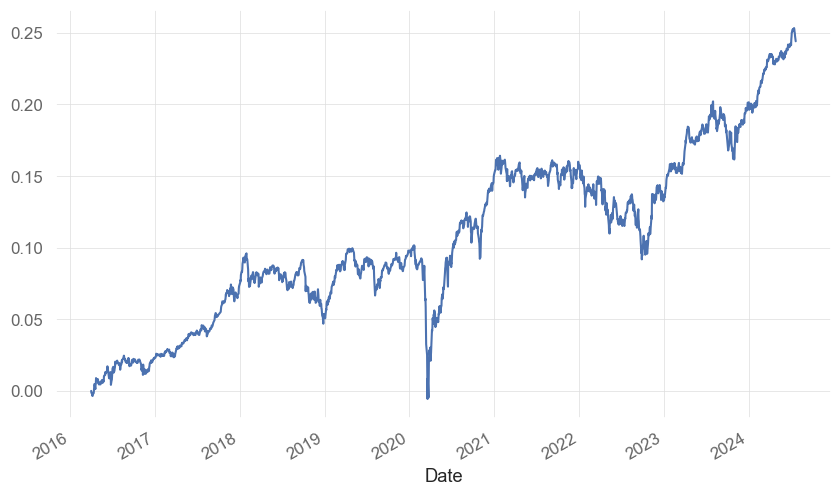

In [20]:
backtest.plot_cum_return()

In [21]:
backtest.show_available_stats()

['adjusted_sortino',
 'autocorr_penalty',
 'avg_loss',
 'avg_return',
 'avg_win',
 'best',
 'cagr',
 'calmar',
 'common_sense_ratio',
 'comp',
 'compare',
 'compsum',
 'conditional_value_at_risk',
 'consecutive_losses',
 'consecutive_wins',
 'cpc_index',
 'cvar',
 'distribution',
 'drawdown_details',
 'expected_return',
 'expected_shortfall',
 'exposure',
 'gain_to_pain_ratio',
 'geometric_mean',
 'ghpr',
 'greeks',
 'implied_volatility',
 'information_ratio',
 'kelly_criterion',
 'kurtosis',
 'max_drawdown',
 'monthly_returns',
 'omega',
 'outlier_loss_ratio',
 'outlier_win_ratio',
 'outliers',
 'payoff_ratio',
 'pct_rank',
 'probabilistic_adjusted_sortino_ratio',
 'probabilistic_ratio',
 'probabilistic_sharpe_ratio',
 'probabilistic_sortino_ratio',
 'profit_factor',
 'profit_ratio',
 'r2',
 'r_squared',
 'rar',
 'recovery_factor',
 'remove_outliers',
 'risk_of_ruin',
 'risk_return_ratio',
 'rolling_greeks',
 'rolling_sharpe',
 'rolling_sortino',
 'rolling_volatility',
 'ror',
 'seren

In [23]:
backtest.get_stat('sharpe')

0.717179587147391

In [24]:
backtest.show_available_plots()

['daily_returns',
 'distribution',
 'drawdown',
 'drawdowns_periods',
 'earnings',
 'histogram',
 'log_returns',
 'monthly_heatmap',
 'monthly_returns',
 'plotly',
 'returns',
 'rolling_beta',
 'rolling_sharpe',
 'rolling_sortino',
 'rolling_volatility',
 'snapshot',
 'to_plotly',
 'warnings',
 'yearly_returns']

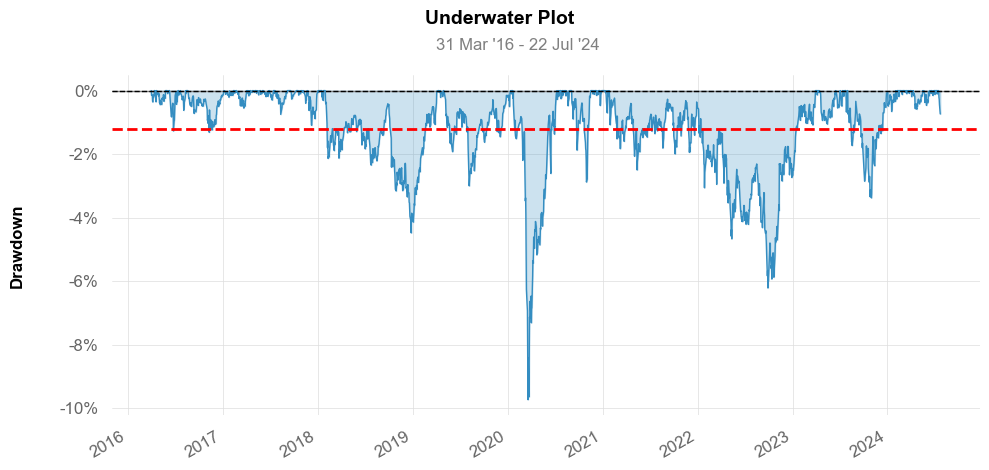

In [25]:
backtest.get_plot('drawdown')

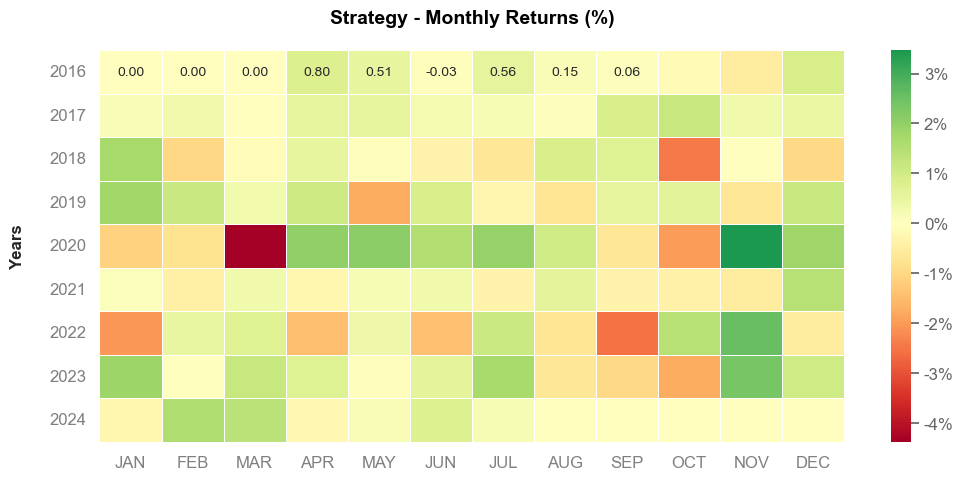

In [26]:
backtest.get_plot('monthly_heatmap')